In [30]:
import numpy as np
import pandas as pd
import math
import time
import matplotlib

import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import cross_val_score

from scipy.stats import skew
from scipy.stats.stats import pearsonr

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

matplotlib.style.use('ggplot')

In [31]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, Y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

## Sobre os dados

Os dados a seguir se referem a notas de alunos no primeiro e segundo período do curso de Ciência da Computação
da Universidade Federal de Campina Grande. 

In [32]:
df = pd.DataFrame.from_csv('../data/treino.csv')

/Users/antonioricardojr/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  if __name__ == '__main__':


In [33]:
df.head()

,Vetorial,LPT,P1,IC,LP1,Cálculo2,Discreta,P2,Grafos,Fís.Clássica,LP2,cra,Cálculo1
matricula,,,,,,,,,,,,,
0cc3d63edf0b986cb87e345972857e15,8.6,10.0,9.0,9.1,8.6,8.4,8.3,8.8,8.2,7.9,9.4,8.477647,8.7
0d78246db769dc958ce19fc414050b2a,5.6,7.0,7.7,7.0,8.1,6.2,7.3,8.2,5.4,7.7,8.9,6.851724,7.0
0f5bb983df06b90337dc2c6301fef3f6,10.0,9.8,7.9,9.6,8.3,8.7,8.8,9.5,9.2,8.6,9.7,9.090588,8.6
1307a4421a67a497cea198e8ccfb97ee,6.1,8.3,6.8,8.2,7.1,8.0,6.3,8.9,7.0,8.5,9.0,7.283516,7.8
1432d50cf8519694ab992c414d90a130,8.8,9.3,5.0,8.5,5.1,5.0,5.8,7.1,5.4,8.7,8.2,7.205747,5.2


A partir dos dados acima, serão construídos modelos de predição afim de predizer a variável **CRA** destes alunos ao
final do curso.

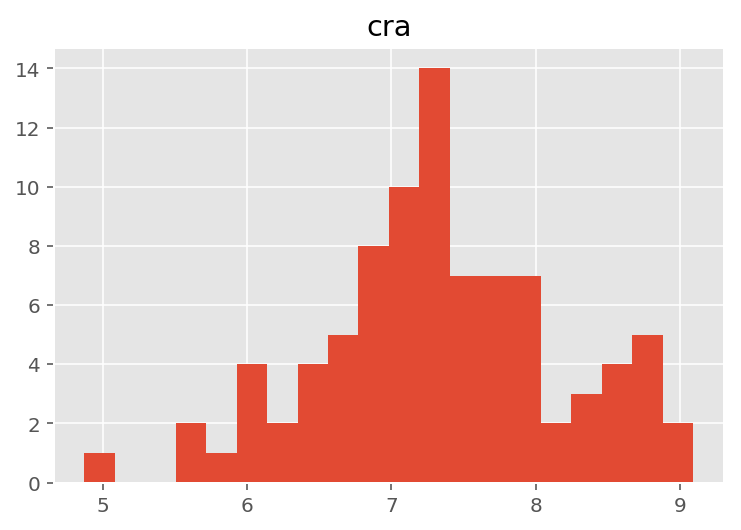

In [34]:
df['cra'].hist(bins = 20)
plt.title('cra')
plt.show()

A partir do histograma acima, é possível perceber um comportamento similar ao da curva normal para o CRA dos alunos.

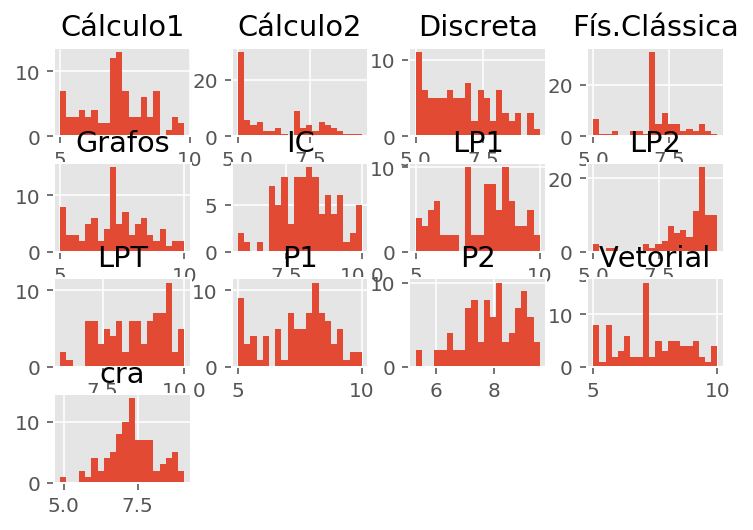

In [35]:
df.hist(bins=20)
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
plt.show()

Ao analisar os histogramas acima, é possível perceber que algumas distribuições parecem estar mais distantes
de um padrão similar a distribuição normal. São estes:

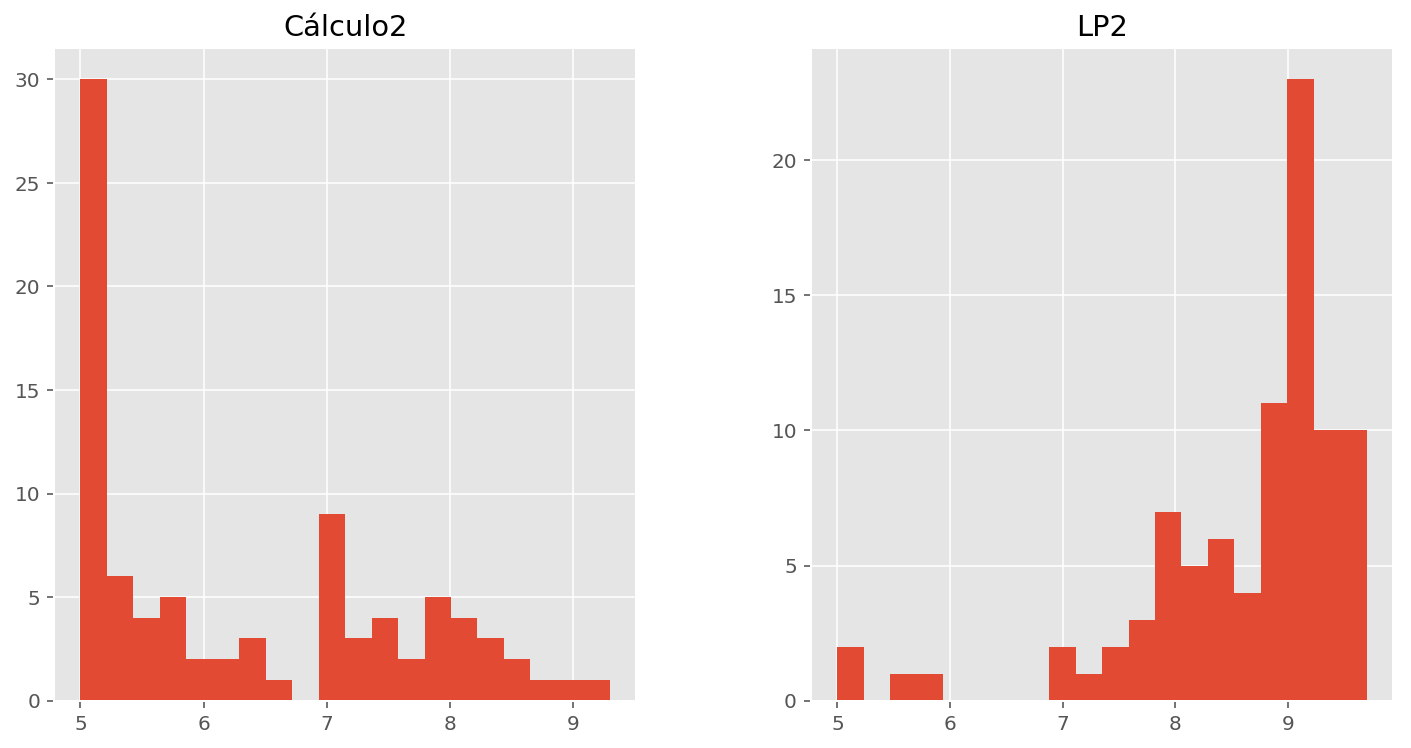

In [36]:
df[['Cálculo2', 'LP2']].hist(bins=20)
matplotlib.rcParams['figure.figsize'] = (8.0, 6.0)
plt.show()

A distribuição para a variável LPT apresenta uma positive skew, enquanto que LP2 apresentaa uma negative skew.
Para minimizar este efeito nos dados, normalmente é aplicado o log na variável, afim de diminuir o skew. No entanto,
como o range de valores se encontra muito próximo (escala de 0 a 10), o log não ajuda nesta tarefa

## Separando dados em Treino e Teste

In [37]:
msk = np.random.rand(len(df)) < 0.8

train = df[msk]
test = df[~msk]

In [38]:
X_train = train.drop('cra', axis=1)
Y_train = train.cra

In [39]:
X_test = test.drop('cra', axis=1)
Y_test = test.cra

## Modelos e hiperparâmetros utilizados

### Hiperparâmetros

In [40]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]

### Ridge

In [41]:
cv_ridge = [rmse_cv(linear_model.Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

Text(0,0.5,'rmse')

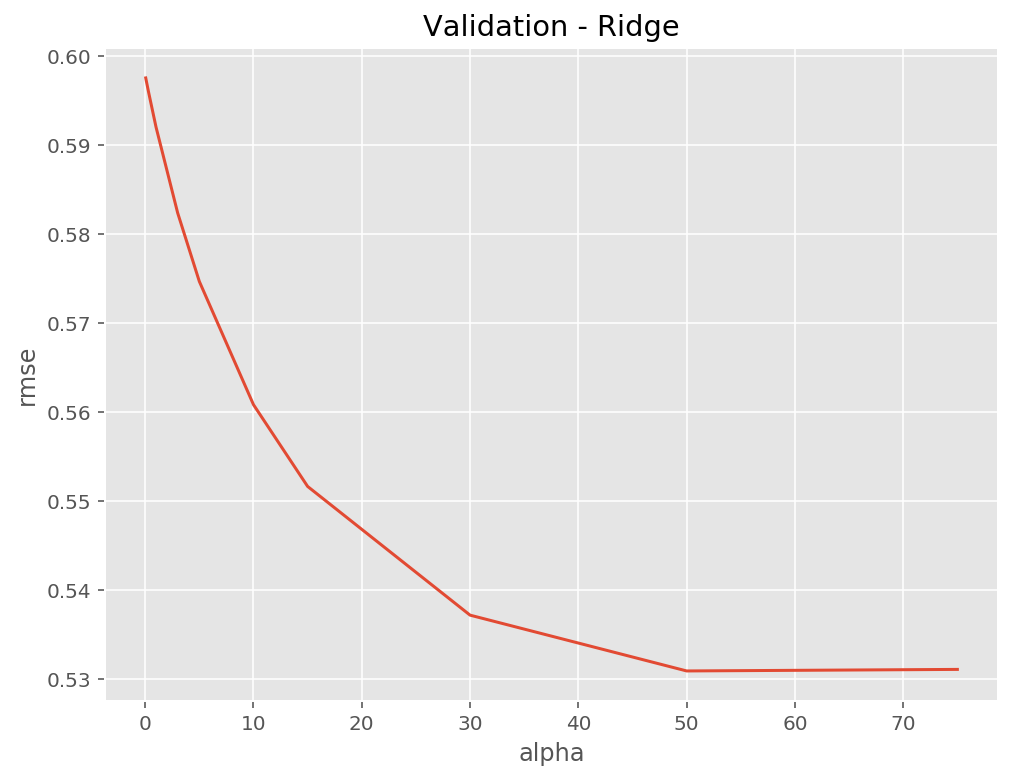

In [42]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Ridge")
plt.xlabel("alpha")
plt.ylabel("rmse")

De acordo com o gráfico acima, será utilizado o alpha igual a 50 para treinar este modelo.

In [43]:
model_ridge = linear_model.RidgeCV(alphas = [50.0]).fit(X_train, Y_train)
rmse_cv(model_ridge).min()

0.3645879176571477

In [44]:
coef_ridge = pd.Series(model_ridge.coef_, index = X_train.columns)

Text(0.5,1,'Coefficients in the Ridge Model')

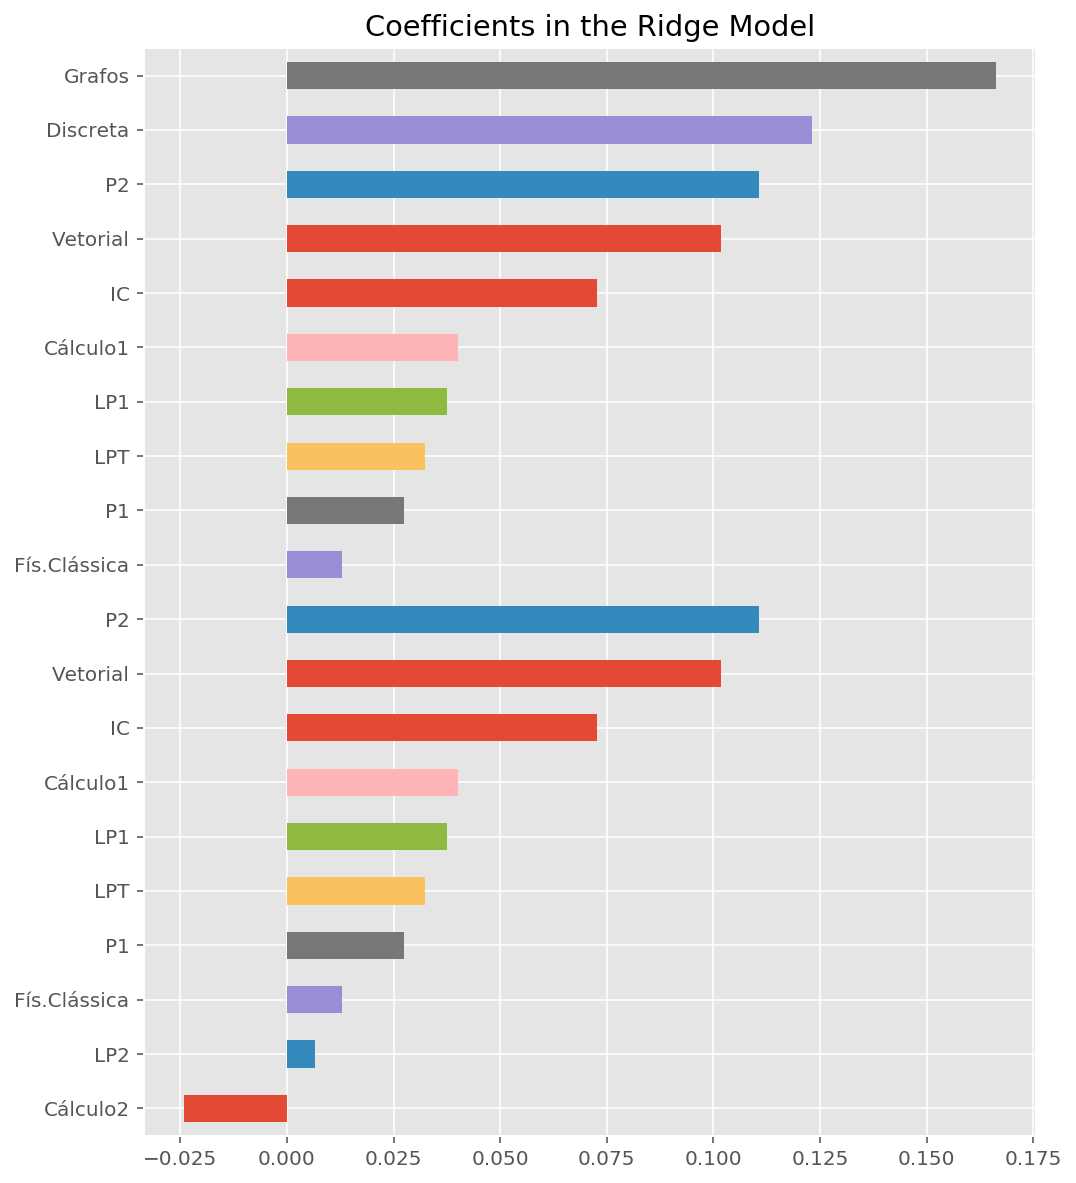

In [45]:
imp_coef_ridge = pd.concat([coef_ridge.sort_values().head(10),
                     coef_ridge.sort_values().tail(10)])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef_ridge.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")

### Previsão Ridge

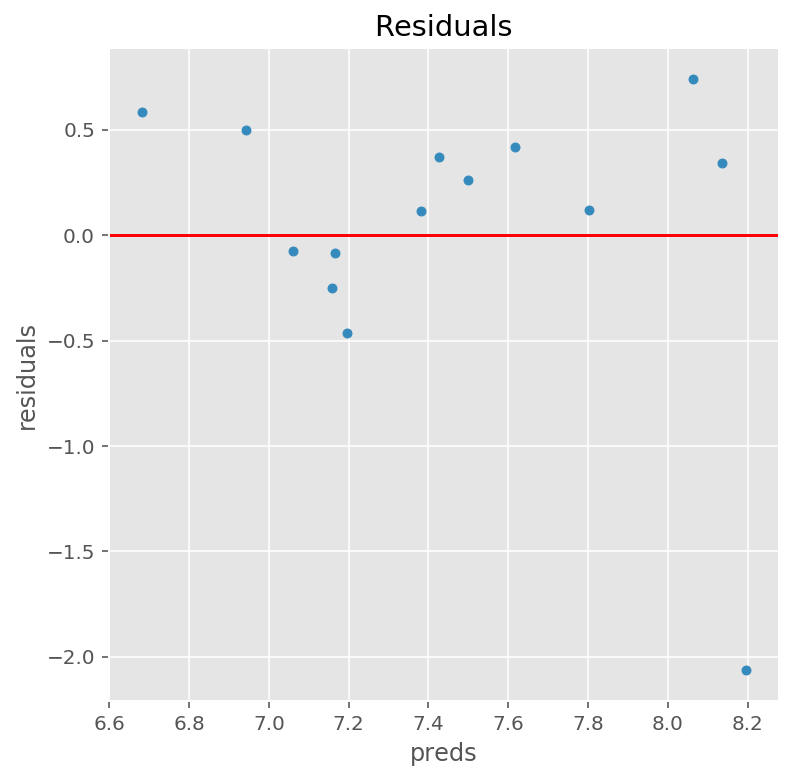

In [46]:
#let's look at the residuals as well:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_ridge.predict(X_test), "true":Y_test})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter", title="Residuals")
plt.axhline(0, color='red')

### Lasso

In [47]:
cv_lasso = [rmse_cv(linear_model.Lasso(alpha = alpha)).mean() 
            for alpha in alphas]

Text(0,0.5,'rmse')

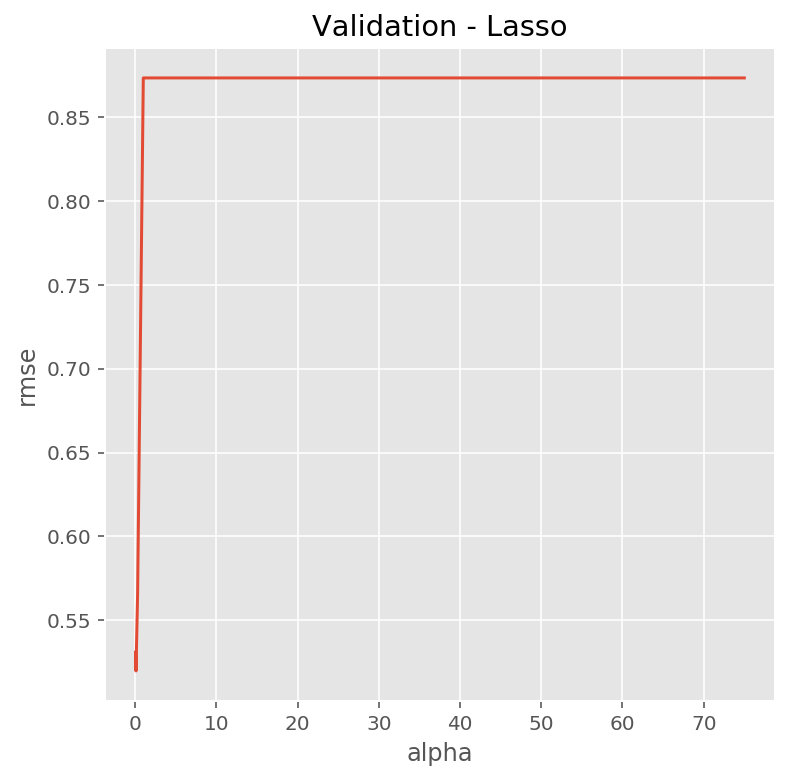

In [48]:
cv_lasso = pd.Series(cv_lasso, index = alphas)
cv_lasso.plot(title = "Validation - Lasso")
plt.xlabel("alpha")
plt.ylabel("rmse")

Como o RMSE aumenta consideravelmente com o aumento do alpha, foi utilizado um alpha bem baixo para este modelo.

In [49]:
model_lasso = linear_model.LassoCV(alphas = [0.0001]).fit(X_train, Y_train)

In [50]:
coef_lasso = pd.Series(model_lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coef_lasso != 0)) + " variables and eliminated the other " +  str(sum(coef_lasso == 0)) + " variables")

Lasso picked 12 variables and eliminated the other 0 variables


Text(0.5,1,'Coefficients in the Lasso Model')

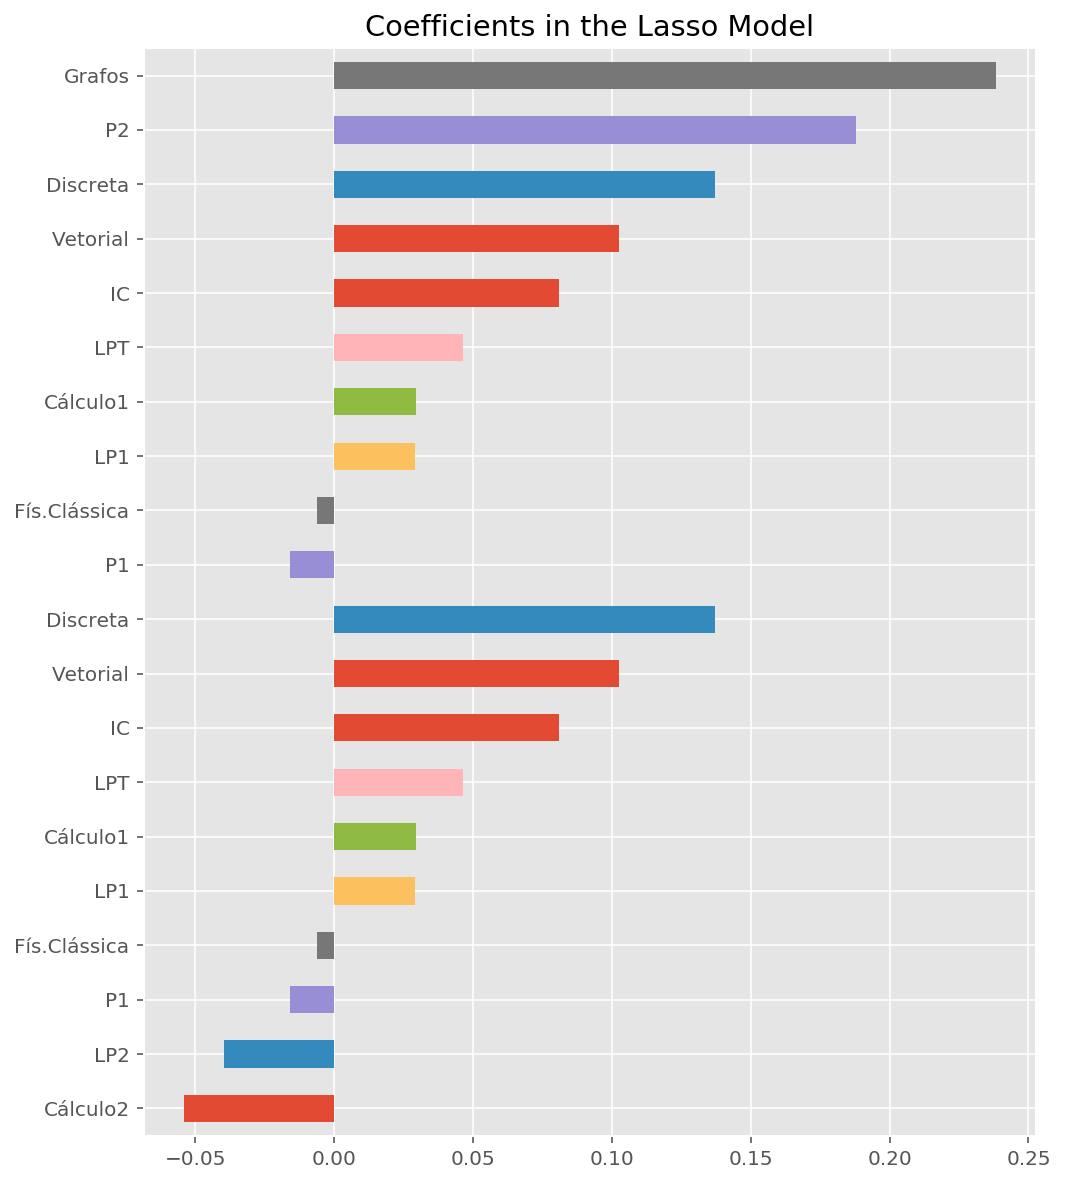

In [51]:
imp_coef_lasso = pd.concat([coef_lasso.sort_values().head(10),
                     coef_lasso.sort_values().tail(10)])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef_lasso.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

### Previsão Lasso

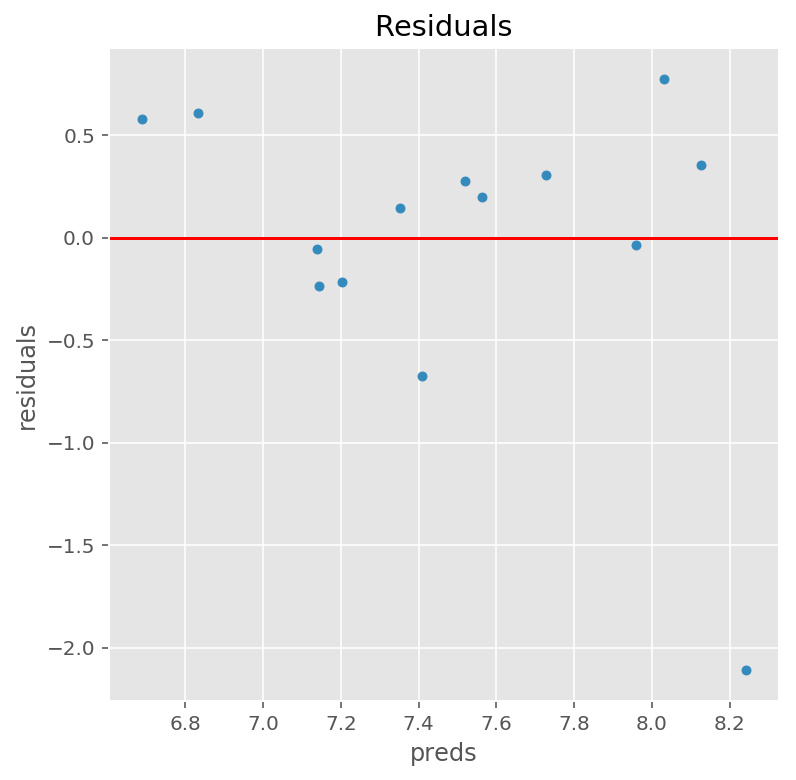

In [52]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_test), "true":Y_test})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter", title="Residuals")
plt.axhline(0, color='red')

### Kernel Ridge

In [53]:
cv_kernel_ridge = [rmse_cv(KernelRidge(alpha = alpha)).mean() 
            for alpha in alphas]

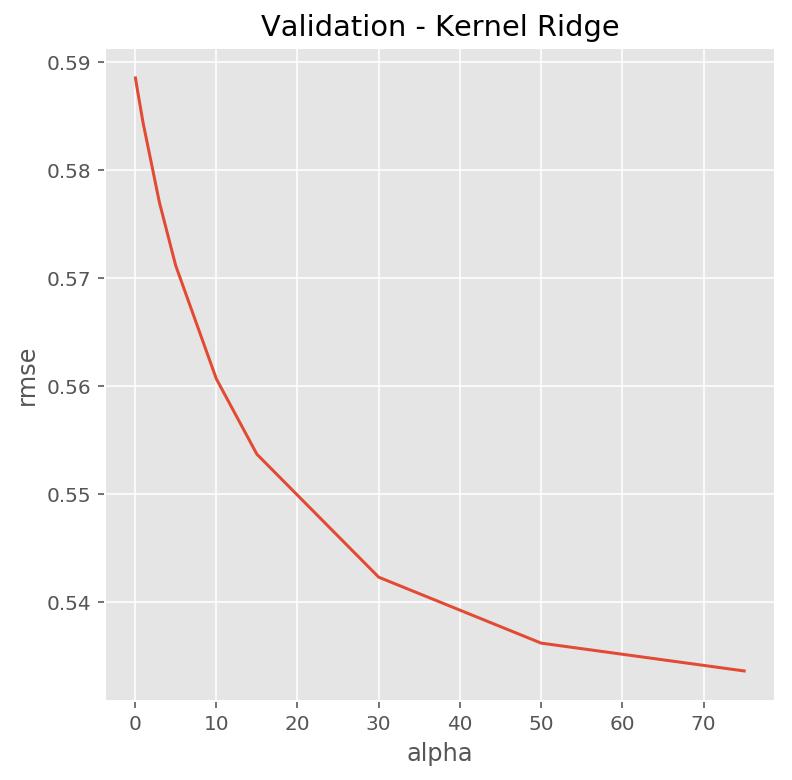

In [54]:
cv_kernel_ridge = pd.Series(cv_kernel_ridge, index = alphas)
cv_kernel_ridge.plot(title = "Validation - Kernel Ridge")
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.savefig('rmses_kernel_ridge.png')

Pelo gráfico acima, o alpha escolhido para o treinamento é igual a 70.

In [55]:
model_kernel_ridge = KernelRidge(alpha = [70]).fit(X_train, Y_train)
rmses = rmse_cv(model_kernel_ridge)
rmses

array([0.45062523, 0.42067358, 0.64622884, 0.55072229, 0.60148219])

### Previsão Kernel Ridge

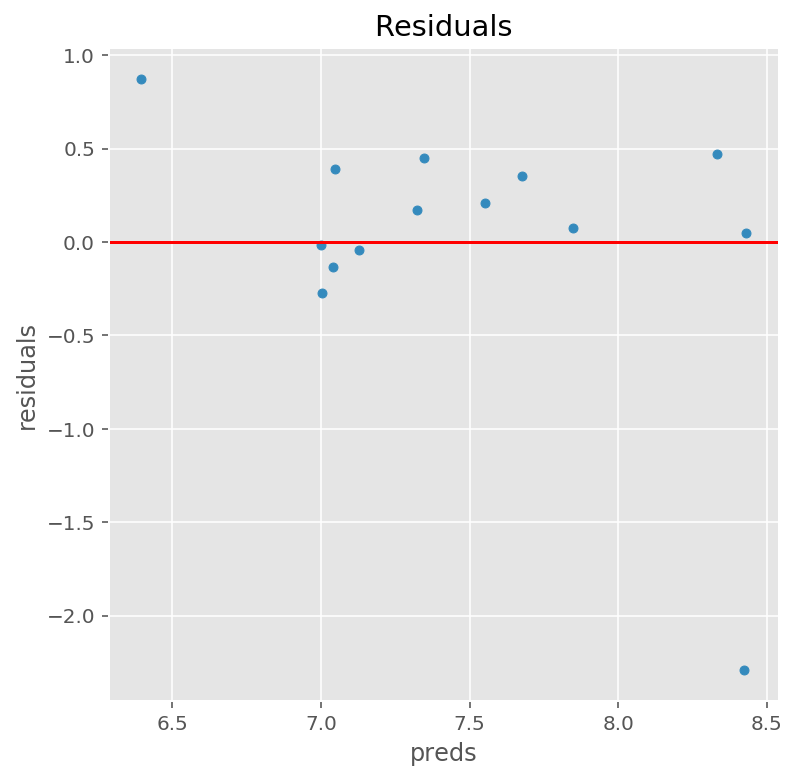

In [56]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_kernel_ridge.predict(X_test), "true":Y_test})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter", title="Residuals")
plt.axhline(0, color='red')

### Conclusões sobre as previsões 

Através dos gráficos de resíduos apresentados, os modelos parecem errar de forma semelhante, 
com um pequeno destaque para o Kernel Ridge e o Lasso, que possuem boa parte dos resíduos dentro de uma faixa